In [68]:
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')

# Load data:
regression_results = pd.read_csv("../results/multioutput/regression/regr_results_all_feat.csv", index_col=0)
mol_feat = pd.read_csv("../results/multioutput/regression/regr_results_mol_feat.csv", index_col=0)
fingerprint_feat = pd.read_csv("../results/multioutput/regression/regr_results_fingerprints.csv", index_col=0)



In [69]:
regression_results = regression_results.rename(columns={"prediction": "pred_all_feat"})
regression_results["pred_mol_feat"] = mol_feat["prediction"]
regression_results["pred_fingerprints_feat"] = fingerprint_feat["prediction"]


In [70]:
regression_results = regression_results.rename(columns={"pred_all_feat": "prediction"})
# regression_results


,matrix,polarity,regressor,observed_value,prediction,Matrix short,Polarity,name_short,adduct,pred_mol_feat,pred_fingerprints_feat
0,NaN,NaN,Lin_reg,0.0,-2.839341e+10,9AA,negative,2-Oxoglutaric acid,+Cl,0.127882,-0.318970
1,NaN,NaN,Lin_reg,0.0,-4.972183e+10,9AA,positive,2-Oxoglutaric acid,+Cl,0.042844,-0.000488
2,NaN,NaN,Lin_reg,0.0,-1.612038e+10,CHCA,negative,2-Oxoglutaric acid,+Cl,-0.040895,-0.110222
3,NaN,NaN,Lin_reg,0.0,-7.512883e+10,CHCA,positive,2-Oxoglutaric acid,+Cl,-0.312602,-0.154297
4,NaN,NaN,Lin_reg,0.0,-1.040662e+10,CMBT,negative,2-Oxoglutaric acid,+Cl,-0.008503,-0.017868
...,...,...,...,...,...,...,...,...,...,...,...
60055,NaN,NaN,GaussianProcessMultiOut,0.0,5.759809e-01,NEDC,positive,gamma-Aminobutyric acid,[M]-,-0.026397,0.107196
60056,NaN,NaN,GaussianProcessMultiOut,0.0,4.076080e-01,NOR,negative,gamma-Aminobutyric acid,[M]-,-0.003206,0.255658
60057,NaN,NaN,GaussianProcessMultiOut,0.0,4.406984e-01,NOR,positive,gamma-Aminobutyric acid,[M]-,-0.091748,-0.130870
60058,NaN,NaN,GaussianProcessMultiOut,0.0,1.862839e-01,pNA,negative,gamma-Aminobutyric acid,[M]-,0.017021,0.025133


In [71]:
# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
regression_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'regressor', "Spearman's R", 
                                             'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs'])
counter = 0
for (matrix, polarity, regressor), rows in regression_results.groupby(['Matrix short', 'Polarity', 'regressor']):
    # remove zero intensity molecules if needed (optional)
    rows = rows[rows['observed_value']!=0]
    
    spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
    pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
    mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
    mse_std = mse / rows['observed_value'].std()
    regression_metrics.loc[counter] = [matrix, polarity, regressor, spearman[0], spearman[1], 
                                       pearson[0], pearson[1], mse, mse_std, 
                                       rows[rows['observed_value']!=0].shape[0]]
    counter += 1

In [72]:
# select best regressor for each matrix/polarity combination
best_RMSE = regression_metrics.loc[regression_metrics.groupby(['matrix', 'polarity'])["RMSE/std"].idxmin()]
#best_RMSE

best_spear = regression_metrics.loc[regression_metrics.groupby(['matrix', 'polarity'])["Spearman's R"].idxmax()].sort_values("Spearman's R", ascending=False)
best_spear

,matrix,polarity,regressor,Spearman's R,S pval,Pearson's R,P pval,RMSE,RMSE/std,non-zero obs
9,9AA,negative,RandomForest,0.745471,7.066228e-31,0.683869,2.312679e-24,1.681396,0.766526,167
22,9AA,positive,RandomForest,0.647281,1.492288e-13,0.684512,1.564091e-15,1.232718,0.756134,103
61,CMBT,negative,RandomForest,0.619202,2.826969e-07,0.441913,5.785716e-04,0.549919,0.985802,57
217,NOR,negative,RandomForest,0.618408,4.336882e-17,0.495378,1.337387e-10,1.462239,0.929936,149
230,NOR,positive,RandomForest,0.605522,2.211668e-17,0.624746,1.061220e-18,1.196835,0.823233,160
196,NEDC,positive,DecisionTreeMultiOut,0.587999,6.310839e-09,0.214028,5.350892e-02,0.712429,1.171802,82
126,DAN,positive,RandomForest,0.584580,1.503985e-20,0.639602,1.936323e-25,0.843805,0.794660,209
51,CHCA,positive,SVR_rbf,0.571282,3.850723e-32,0.466665,1.340881e-20,1.396499,0.989684,355
88,ClCCA,negative,RandomForestMultiOut,0.569279,1.123666e-06,0.124220,3.320555e-01,0.381756,1.053334,63
76,CMBT,positive,SVR_poly,0.561497,5.338479e-24,0.491326,6.183796e-18,0.997073,0.894384,272


,matrix,polarity,regressor,observed_value,prediction,Matrix short,Polarity,name_short,adduct,pred_mol_feat,pred_fingerprints_feat
0,NaN,NaN,RandomForest,0.0,0.020666,9AA,negative,2-Oxoglutaric acid,+Cl,0.021561,0.020015
1,NaN,NaN,RandomForest,0.0,0.004053,9AA,positive,2-Oxoglutaric acid,+Cl,0.000308,0.002139
2,NaN,NaN,RandomForest,0.0,0.000030,CHCA,negative,2-Oxoglutaric acid,+Cl,0.000000,0.000000
3,NaN,NaN,RandomForest,0.0,0.003817,CHCA,positive,2-Oxoglutaric acid,+Cl,0.004201,0.003901
4,NaN,NaN,RandomForest,0.0,0.000425,CMBT,negative,2-Oxoglutaric acid,+Cl,0.000396,0.000285
...,...,...,...,...,...,...,...,...,...,...,...
23655,NaN,NaN,RandomForest,0.0,0.001376,NEDC,positive,gamma-Aminobutyric acid,[M]-,0.008053,0.001526
23656,NaN,NaN,RandomForest,0.0,0.001088,NOR,negative,gamma-Aminobutyric acid,[M]-,0.000015,0.001219
23657,NaN,NaN,RandomForest,0.0,0.006611,NOR,positive,gamma-Aminobutyric acid,[M]-,0.000858,0.005518
23658,NaN,NaN,RandomForest,0.0,0.000327,pNA,negative,gamma-Aminobutyric acid,[M]-,0.000235,0.000400


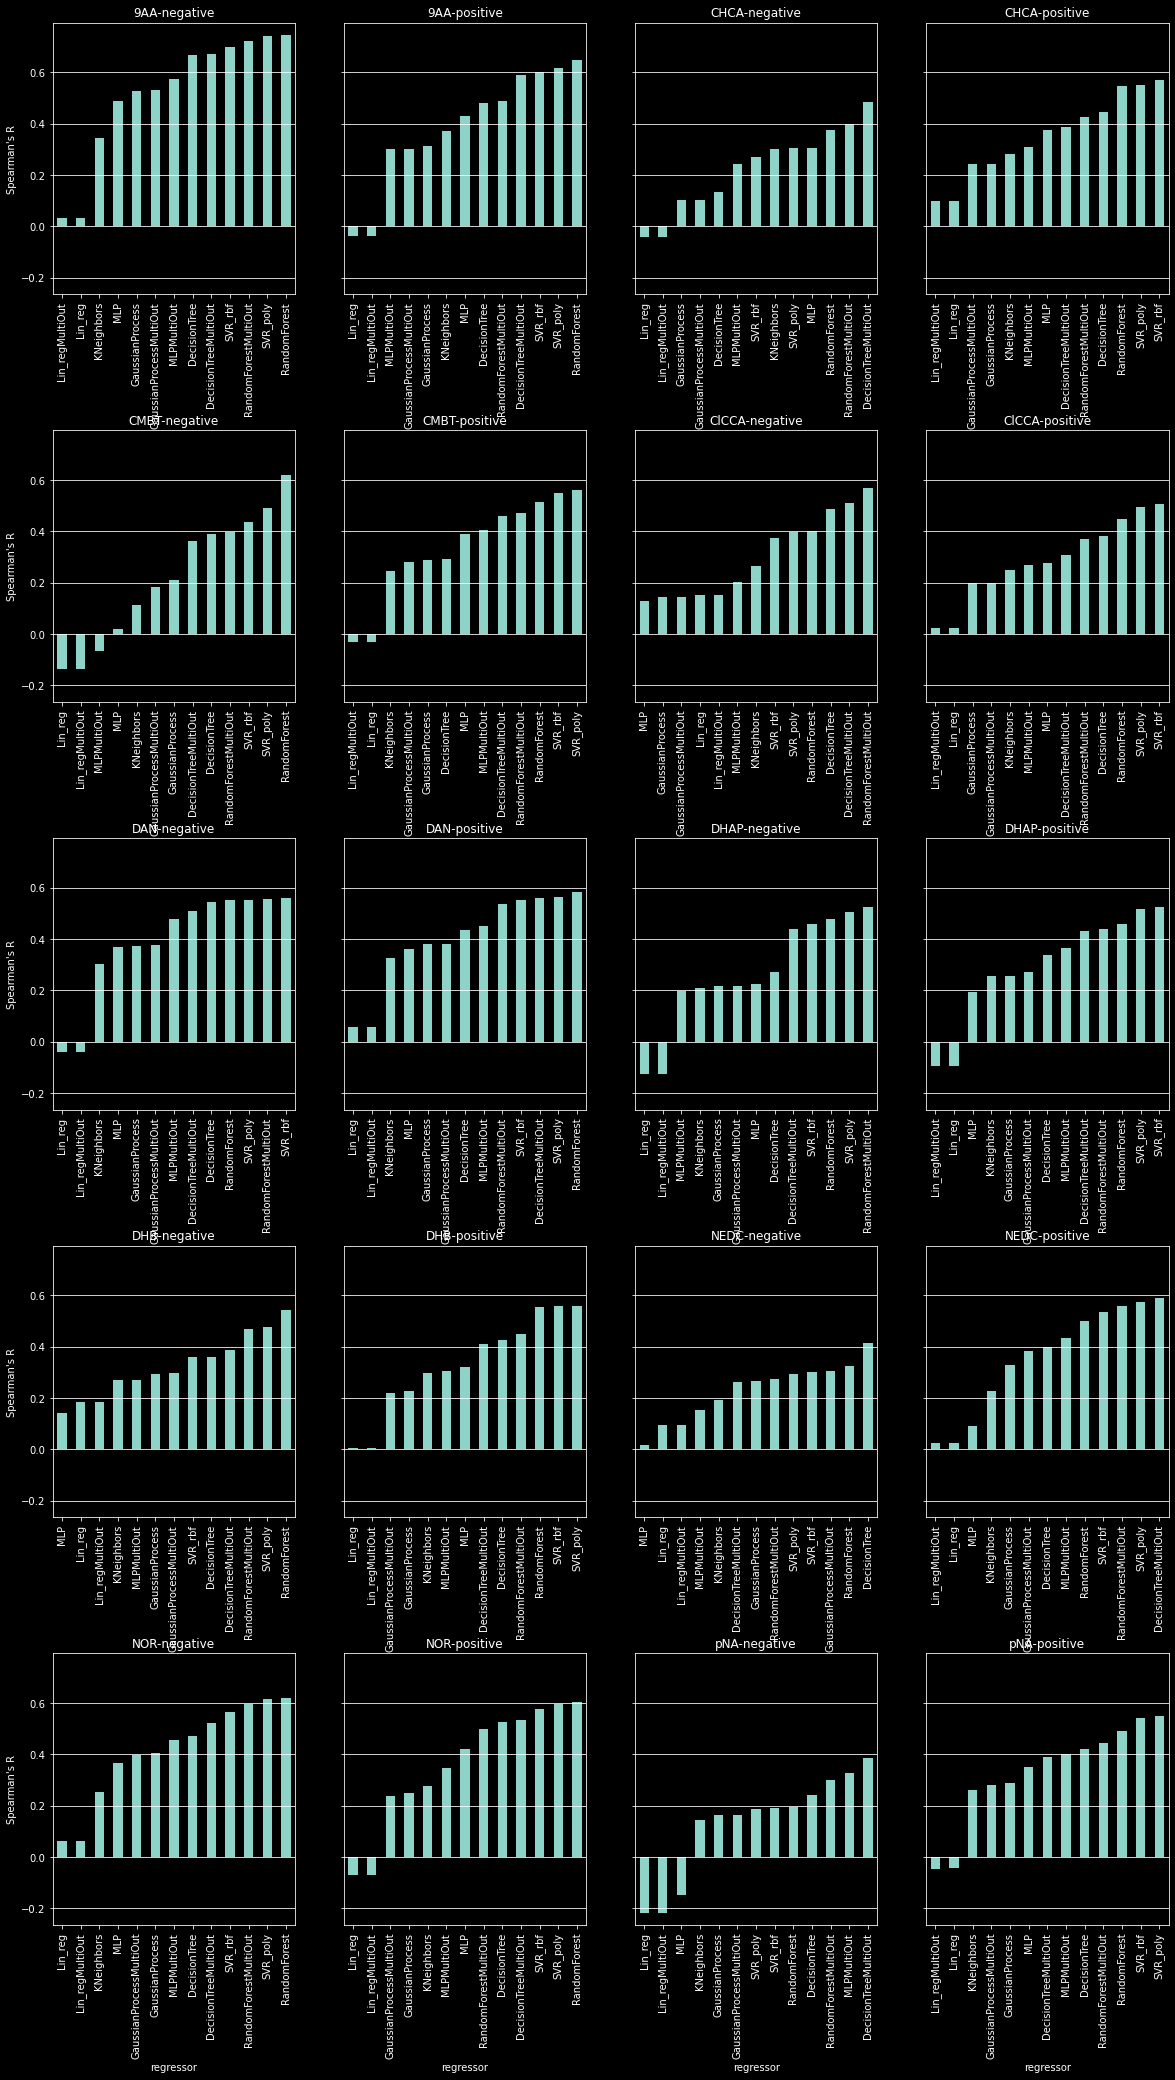

In [73]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in regression_metrics.groupby(['matrix', 'polarity']):
    rows = rows.set_index('regressor', drop = True).sort_values( by = metric)
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    i+=1

plt.subplots_adjust(hspace=0.5)

plt.show()

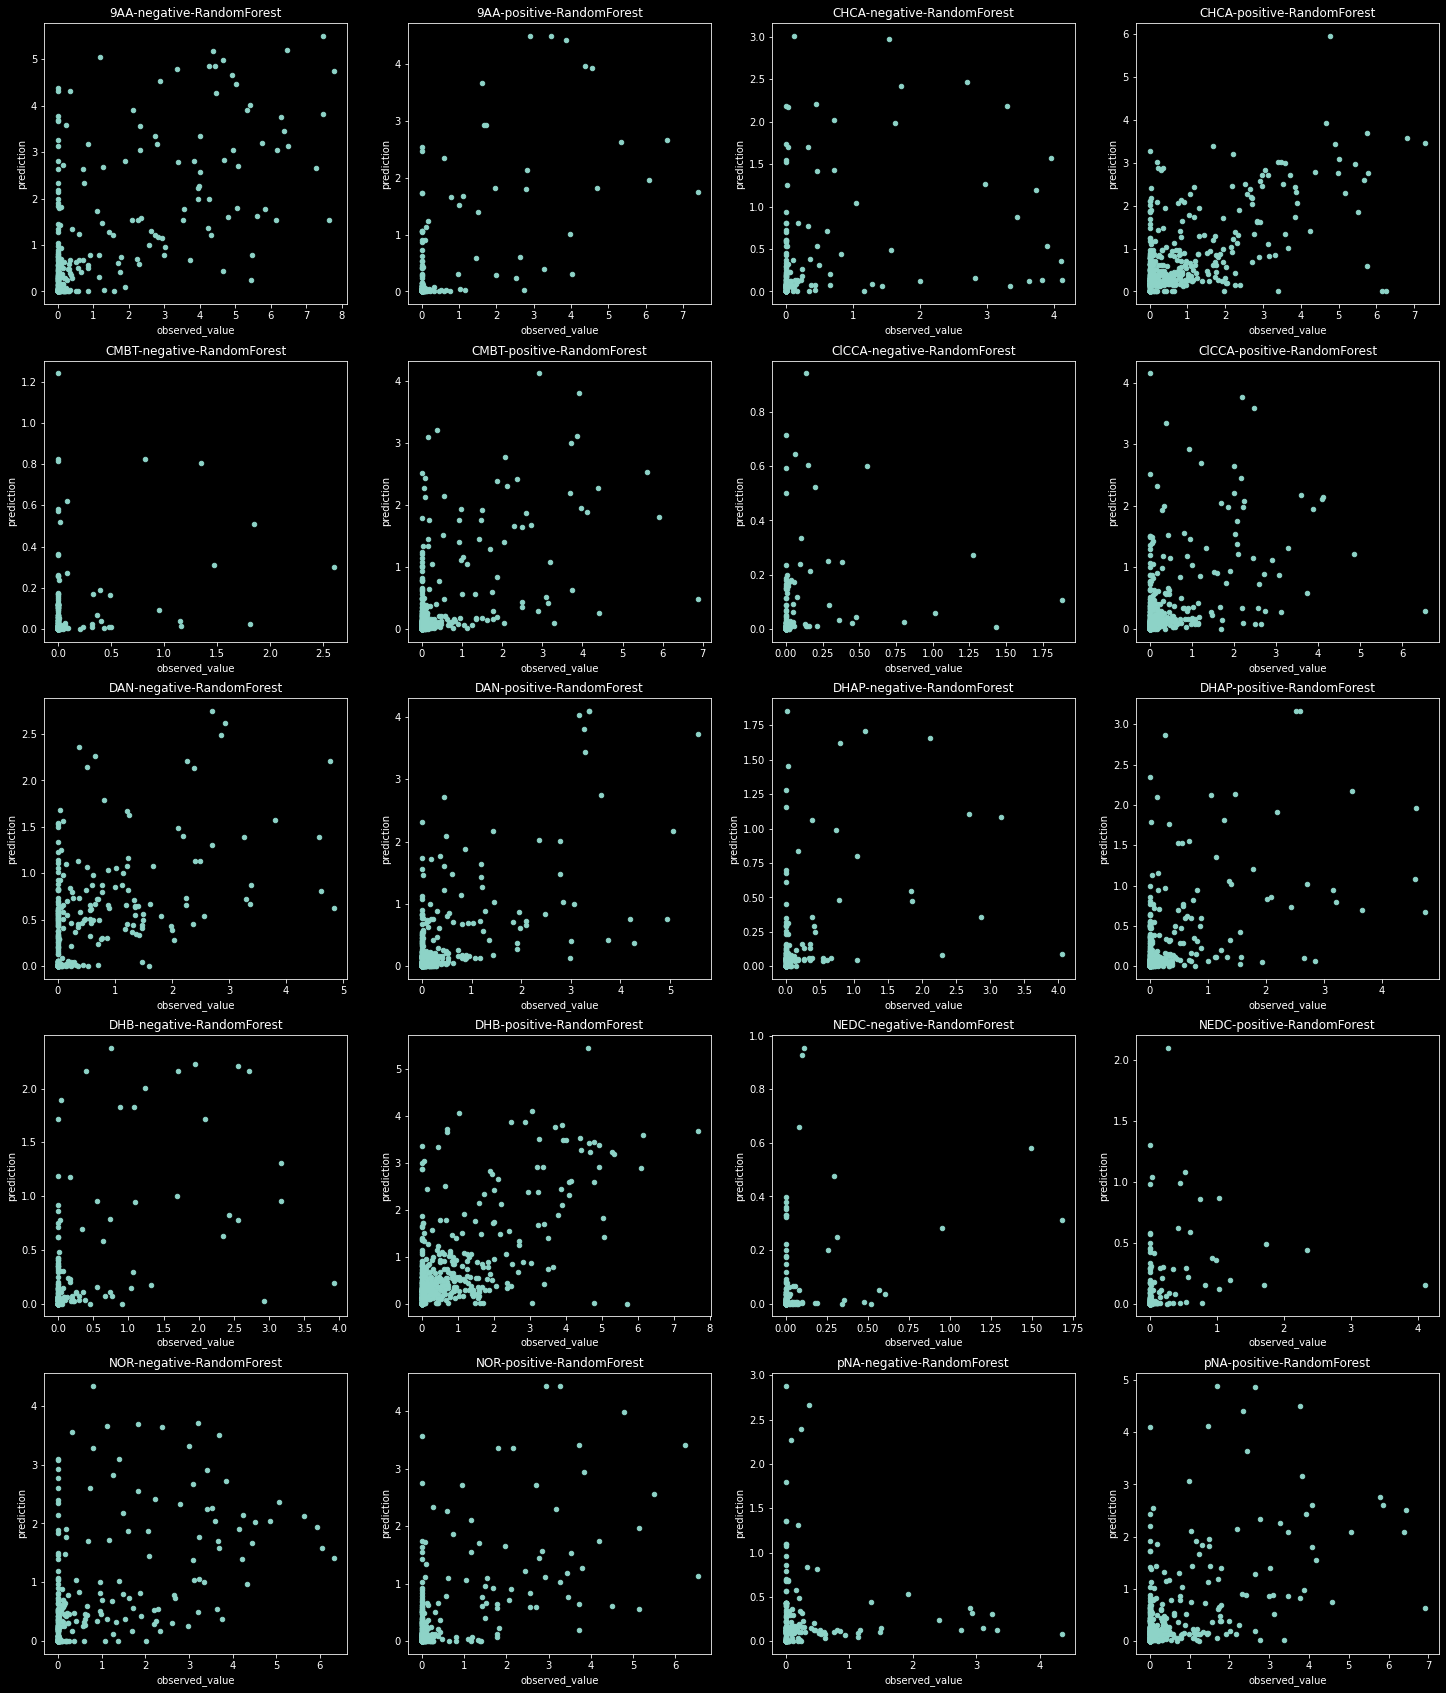

In [75]:
fig, axes = plt.subplots(ncols=4,nrows=5, figsize= (25, 30))
ax_list = axes.flat

regressor = "RandomForest"

i = 0
for (matrix, polarity), rows in regression_results.groupby(['Matrix short', 'Polarity']):
    rows[rows.regressor == regressor].plot.scatter(x = 'observed_value', y= 'prediction',
                                                   ax = ax_list[i], title=f"{matrix}-{polarity}-{regressor}")
    i+=1

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

### Matrix prediction accuracy
Check if the best matrix is selected for each ion with a selected regressor


Ignore molecules that were never observed

In [39]:
# Get rid of molecules that were never detected from results dt:
g = regression_results.groupby(['name_short', 'adduct'], as_index=False)["observed_value"].max()
regression_results = pd.merge(regression_results, g[g["observed_value"] >= 0.][["adduct", "name_short"]],
        how="inner")

accuracy_df = pd.DataFrame(columns = ['regressor', 'accuracy'])
for i, selected_regressor in enumerate(regression_results["regressor"].unique()):
    accuracy = 0
    for (molecule, adduct), rows in regression_results[regression_results.regressor == selected_regressor].groupby(['name_short', 'adduct']):
        # print(rows["observed_value"].idxmax(), rows.loc[rows["observed_value"].idxmax(), ["matrix", "polarity"]])
        best_observed = rows.loc[rows["observed_value"].idxmax(), ["matrix", "polarity"]]
        # Warning: idxmax() returns the first row (even in case of ties)
        best_predicted = rows.loc[rows["prediction"].idxmax()][["matrix", "polarity"]]

        # If all observed intensities were zeros, let's check if all predicted intensities were also low:
        if rows["observed_value"].max() <= 0.:
            # FIXME: for the moment we use arbitrary number
            # print(rows["prediction"].max())
            if rows["prediction"].max() <= 0.05: accuracy += 1
        else:
            if (best_observed == best_predicted).all(): accuracy += 1
        # else:
        #     print("Warning: multiple predictions with same intensity")
        #     if len(pd.merge(best_observed, best_predicted)) > 0: accuracy += 1

    accuracy = accuracy / regression_results[regression_results.regressor == selected_regressor][['name_short', 'adduct']].drop_duplicates().shape[0]
    accuracy_df.loc[i] = [selected_regressor, accuracy]


In [40]:
accuracy_df.sort_values("accuracy", ascending=False)

,regressor,accuracy
4,KNeighbors,0.288250
5,DecisionTree,0.229924
7,RandomForest,0.229079
6,DecisionTreeMultiOut,0.204565
8,RandomForestMultiOut,0.164835
0,Lin_reg,0.046492
1,Lin_regMultiOut,0.046492
11,GaussianProcess,0.046492
12,GaussianProcessMultiOut,0.046492
10,MLPMultiOut,0.028740
